# Latent Dirichlet Allocation & Topic Modelling

https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24

https://github.com/susanli2016/NLP-with-Python/blob/master/LDA_news_headlines.ipynb

https://github.com/FelixChop/MediumArticles/blob/master/LDA-BBC.ipynb

I like to draw an **analogy** between the **Dirichlet Distribution** and the **normal distribution**, since most people understand the normal distribution.

The normal distribution is a probability distribution over all the real numbers. It is described by a mean and a variance. The mean is the expected value of this distribution, and the variance tells us how much we can expect samples to deviate from the mean. If the variance is very high, then you’re going to see values that are both much smaller than the mean and much larger than the mean. If the variance is small, then the samples will be very close to the mean. If the variance goes close to zero, all samples will be almost exactly at the mean.

The dirichlet distribution is a probability distribution as well - but it is not sampling from the space of real numbers. Instead it is sampling over a probability simplex.

And what is a probability simplex? It’s a bunch of numbers that add up to 1. For example:

(0.6, 0.4)
(0.1, 0.1, 0.8)
(0.05, 0.2, 0.15, 0.1, 0.3, 0.2)

These numbers represent probabilities over K distinct categories. In the above examples, K is 2, 3, and 6 respectively. That’s why they are also called categorical distributions.

When we are dealing with categorical distributions and we have some uncertainty over what that distribution is, simplest way to represent that uncertainty as a probability distribution is the Dirichlet.

A K-dimentional Dirichlet distribution has K parameters. These parameters can be any positive number. For example, a 4-dimentional Dirichlet may look like this:

(23, 6, 32, 39)

In the normal case, the mean and the variance tell us what kind of samples to expect. What do the above parameters tell us? Note that these 4 parameters can be normalized (divided by their sum) to form a probability distribution times a normalization constant:

100 * (0.23, 0.06, 0.32, 0.39)

The probabilities that come out of it (23%, 6%, 32%, 39%) just happen to be the mean value of the Dirichlet! So, all samples from it will center around that simplex. The normalization constant - 100 in this case - isn’t the variance but it’s related. The higher it is, the closer samples will be to the mean. 100 is a fairly high weight, so most samples from this distribution will be close to (23%, 6%, 32%, 39%).

When the normalization constant gets very low (close the zero) the variance gets higher and higher. The furthest you can get from a point in the simplex is usually in one of the corners, for example (0, 0, 1, 0). When the normalization constant gets low, not only do we expect to be far away from the mean. We actually expect to flip to one of the corners of the simplex with probabilities as described by the mean.

https://www.quora.com/What-is-an-intuitive-explanation-of-the-Dirichlet-distribution

<img src="pictures/LDA2VEC.png">

### 1. Load Data

In [ ]:
import os
import pandas as pd

PATH = 'C:/Users/adsieg/Desktop/link_news/ML'

df = pd.read_csv(os.path.join(PATH,'Consumer_Complaints.csv'))
data_text = df[pd.notnull(df['Consumer complaint narrative'])][['Consumer complaint narrative']].reset_index(drop=True)
data_text['index'] = data_text.index
documents = data_text.copy()

documents = documents.sample(frac=0.01, replace=True, random_state=1)

In [ ]:
documents.head()

### 2. Data Preprocessing

In [ ]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)

import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

import nltk
nltk.download('wordnet')

In [ ]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

def preprocess(raw_text):

    # keep only words
    letters_only_text = re.sub("[^a-zA-Z]", " ", raw_text)

    # convert to lower case and split 
    words = letters_only_text.lower().split()

    # remove stopwords
    stopword_set = set(stopwords.words("english"))
    meaningful_words = [w for w in words if w not in stopword_set]
    
    #stemmed words
    ps = PorterStemmer()
    stemmed_words = [ps.stem(word) for word in meaningful_words]
    
    # join the cleaned words in a list
    #cleaned_word_list = " ".join(stemmed_words)

    return stemmed_words

In [ ]:
doc_sample = documents[documents['index'] == 5192].values[0][0]

print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))

In [ ]:
processed_docs = documents['Consumer complaint narrative'].map(preprocess)

In [ ]:
processed_docs.head(10)

### 3. A - Bag of words

In [ ]:
dictionary = gensim.corpora.Dictionary(processed_docs)

In [ ]:
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

In [ ]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [ ]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[4310]

In [ ]:
bow_doc_4310 = bow_corpus[4310]

for i in range(len(bow_doc_4310)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_4310[i][0], 
                                                     dictionary[bow_doc_4310[i][0]], 
                                                     bow_doc_4310[i][1]))

### 3.B - TF IDF

In [ ]:
from gensim import corpora, models

tfidf = models.TfidfModel(bow_corpus)

In [ ]:
corpus_tfidf = tfidf[bow_corpus]

In [ ]:
from pprint import pprint

for doc in corpus_tfidf:
    pprint(doc)
    break

###  4.A - Running LDA using Bag of Words

In [ ]:
num_topics = 20

In [ ]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=num_topics, id2word=dictionary, passes=2, workers=2)

In [ ]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

### 4.B - Running LDA using TF-IDF

In [ ]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=num_topics, id2word=dictionary, passes=2, workers=4)

In [ ]:
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

### 5. Classification of the topics

#### A - Performance evaluation by classifying sample document using LDA Bag of Words model

In [ ]:
processed_docs[4310]

In [ ]:
for index, score in sorted(lda_model[bow_corpus[4310]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))

#### B- Performance evaluation by classifying sample document using LDA TF-IDF model

In [ ]:
for index, score in sorted(lda_model_tfidf[bow_corpus[4310]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))

### Testing model on unseen document

In [ ]:
lda_model[bow_corpus[0]]

In [ ]:
%matplotlib inline
import pyLDAvis
import pyLDAvis.gensim
vis = pyLDAvis.gensim.prepare(topic_model=lda_model, corpus=bow_corpus, dictionary=dictionary)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

### Advanced exploration of LDA results

#### 1. Allocation of topics in all documents

In [ ]:
topics = [lda_model_tfidf[corpus_tfidf[i]] for i in range(len(data))]

In [ ]:
def topics_document_to_dataframe(topics_document, num_topics):
    res = pd.DataFrame(columns=range(num_topics))
    for topic_weight in topics_document:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res

In [ ]:
document_topic = pd.concat([topics_document_to_dataframe(topics_document, num_topics=num_topics) for topics_document in topics]).reset_index(drop=True).fillna(0)

In [ ]:
document_topic.head()

In [ ]:
# merge text with 
document_topic_text = document_topic
document_topic_text['index'] = document_topic_text.index
document_topic_text_final = pd.merge(documents, document_topic_text, on = ['index'])

In [ ]:
document_topic_text_final.sort_values(4, ascending=False)[['Digest text', 4]].head(10)

In [ ]:
len(document_topic) == len(data)

In [ ]:
# Which document are about topic 4
document_topic.sort_values(4, ascending=False)[4].head(20)

#### Looking at the distribution of topics in all documents

In [ ]:
%matplotlib inline
import seaborn as sns; sns.set(rc={'figure.figsize':(10,20)})
#document_topic = document_topic.drop('index', 1)
sns.heatmap(document_topic.loc[document_topic.idxmax(axis=1).sort_values().index])

In [ ]:
sns.set(rc={'figure.figsize':(10,5)})
document_topic.idxmax(axis=1).value_counts().plot.bar(color='lightblue')

# Alternatives > LDA with Bokeh 

In [1]:
import gensim
import gensim.corpora as corpora
from gensim import matutils
from gensim.models import CoherenceModel

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
from string import punctuation

from collections import Counter
import re
import numpy as np

from tqdm import tqdm_notebook
tqdm_notebook().pandas()

from functools import reduce

from nltk.corpus import stopwords
stop_words = list(set(stopwords.words('english')))

C:\Users\adsieg\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


https://ahmedbesbes.com/how-to-mine-newsfeed-data-and-extract-interactive-insights-in-python.html

In [2]:
def _removeNonAscii(s): 
    return "".join(i for i in s if ord(i)<128)

def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = text.replace('(ap)', '')
    text = re.sub(r"\'s", " is ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r"\\", "", text)
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)
    text = re.sub('[^a-zA-Z ?!]+', '', text)
    text = _removeNonAscii(text)
    text = text.strip()
    return text

def tokenizer(text):
    text = clean_text(text)    
    tokens = [word_tokenize(sent) for sent in sent_tokenize(text)]
    tokens = list(reduce(lambda x,y: x+y, tokens))
    tokens = list(filter(lambda token: token not in (stop_words + list(punctuation)) , tokens))
    return tokens

In [3]:
import os
import pandas as pd

PATH = 'C:/Users/adsieg/Desktop/link_news/ML'

df = pd.read_csv(os.path.join(PATH,'Consumer_Complaints.csv'))
data_text = df[pd.notnull(df['Consumer complaint narrative'])][['Consumer complaint narrative', 'Product']].reset_index(drop=True)

documents = data_text.sample(frac=0.01, replace=True, random_state=1)

aux = documents.copy()

In [4]:
aux['tokens'] = aux['Consumer complaint narrative'].progress_map(lambda d: tokenizer(d))

In [5]:
bigram = gensim.models.Phrases(aux['tokens'], min_count=5, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
aux['tokens_bigram'] = aux['tokens'].progress_map(lambda tokens: bigram_mod[tokens])

id2word = corpora.Dictionary(aux['tokens_bigram'])
texts = aux['tokens_bigram'].values
corpus = [id2word.doc2bow(text) for text in texts]

In [6]:
def LDA_model(num_topics, passes=1):
    return gensim.models.ldamodel.LdaModel(corpus=tqdm_notebook(corpus, leave=False),
                                               id2word=id2word,
                                               num_topics=num_topics, 
                                               random_state=100,
                                               eval_every=10,
                                               chunksize=2000,
                                               passes=passes,
                                               per_word_topics=True
                                            )

def compute_coherence(model):
    coherence = CoherenceModel(model=model, 
                           texts=aux['tokens_bigram'].values,
                           dictionary=id2word, coherence='c_v')
    return coherence.get_coherence()

def display_topics(model):
    topics = model.show_topics(num_topics=model.num_topics, formatted=False, num_words=10)
    topics = map(lambda c: map(lambda cc: cc[0], c[1]), topics)
    df = pd.DataFrame(list(topics))
    df.index = ['topic_{0}'.format(i) for i in range(model.num_topics)]
    df.columns = ['keyword_{0}'.format(i) for i in range(1, 10+1)]
    return df

def explore_models(df, rg=range(5, 25)):
    id2word = corpora.Dictionary(df['tokens_bigram'])
    texts = df['tokens_bigram'].values
    corpus = [id2word.doc2bow(text) for text in texts]

    models = []
    coherences = []
    
    for num_topics in tqdm_notebook(rg, leave=False):
        lda_model = LDA_model(num_topics, passes=5)
        models.append(lda_model)
        coherence = compute_coherence(lda_model)
        coherences.append(coherence)
      

    fig = plt.figure(figsize=(15, 5))
    plt.title('Choosing the optimal number of topics')
    plt.xlabel('Number of topics')
    plt.ylabel('Coherence')
    plt.grid(True)
    plt.plot(rg, coherences)
    
    return coherences, models

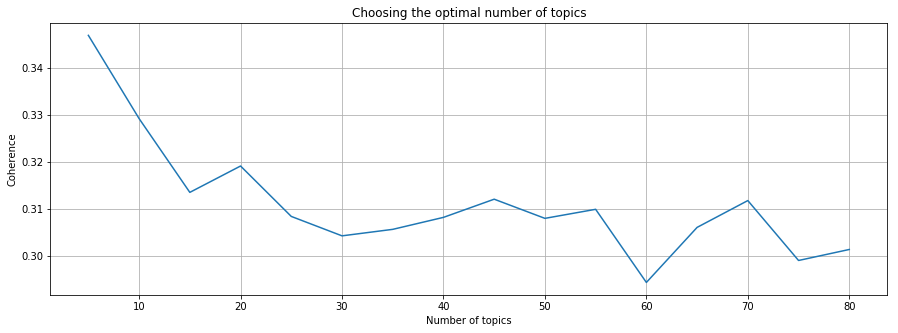

In [8]:
import matplotlib.pyplot as plt
coherences, models = explore_models(aux, rg=range(5, 85, 5))

In [9]:
best_model = LDA_model(num_topics=5, passes=5)

In [10]:
display_topics(model=best_model)

,keyword_1,keyword_2,keyword_3,keyword_4,keyword_5,keyword_6,keyword_7,keyword_8,keyword_9,keyword_10
topic_0,xxxx,loan,payment,would,payments,pay,xx,told,time,mortgage
topic_1,xxxx,account,bank,card,would,told,credit,called,received,could
topic_2,xxxx,xx,credit,account,debt,report,information,payment,loan,received
topic_3,xxxx,mortgage,xx,loan,would,modification,credit,told,sent,call
topic_4,credit,xxxx,account,report,debt,company,information,reporting,accounts,never


In [11]:
def get_document_topic_matrix(corpus, num_topics=best_model.num_topics):
    matrix = []
    for row in tqdm_notebook(corpus):
        output = np.zeros(num_topics)
        doc_proba = best_model[row][0]
        for doc, proba in doc_proba:
            output[doc] = proba
        matrix.append(output)
    matrix = np.array(matrix)
    return matrix

In [12]:
matrix = get_document_topic_matrix(corpus)

In [13]:
doc_topic = best_model.get_document_topics(corpus)
lda_keys = []
for i, desc in enumerate(aux['Consumer complaint narrative']):
    lda_keys.append(np.argmax(matrix[i, :]))

In [17]:
from sklearn.manifold import TSNE

tsne_model = TSNE(n_components=2, verbose=1, random_state=0, n_iter=500)
tsne_lda = tsne_model.fit_transform(matrix)
lda_df = pd.DataFrame(tsne_lda, columns=['x', 'y'])
lda_df['topic'] = lda_keys
lda_df['topic'] = lda_df['topic'].map(str)
aux = aux.reset_index(drop=True)
lda_df['description'] = aux['Consumer complaint narrative']
lda_df['category'] = aux['Product']
lda_df.to_csv('tsne_lda.csv')

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.002s...
[t-SNE] Computed neighbors for 2000 samples in 0.073s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.002708
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.099636
[t-SNE] KL divergence after 500 iterations: 0.368632


In [21]:
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook, reset_output
from bokeh.palettes import d3
import bokeh.models as bmo
from bokeh.io import save, output_file

In [23]:
reset_output()
output_notebook()
plot_lda = bp.figure(plot_width=700, plot_height=600, title="KMeans clustering of the news",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

palette = d3['Category20'][5] + d3['Category20b'][5] 
color_map = bmo.CategoricalColorMapper(factors=lda_df['topic'].unique(), palette=palette)

plot_lda.scatter('x', 'y', source=lda_df, 
                    color={'field': 'topic', 'transform': color_map}, 
                    legend='topic')
hover = plot_lda.select(dict(type=HoverTool))
hover.tooltips={"description": "@description", "topic": "@topic", "category": "@category"}

show(plot_lda)

Loading BokehJS ...

In [24]:
import pyLDAvis
import pyLDAvis.gensim

In [28]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(best_model, corpus, id2word)
pyLDAvis.enable_notebook()
pyLDAvis.display(panel)

C:\Users\adsieg\AppData\Local\Continuum\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


# LDA2Vec

https://www.datacamp.com/community/tutorials/lda2vec-topic-model

Inspired by Latent Dirichlet Allocation (LDA), the word2vec model is expanded to simultaneously learn word, document and topic vectors.

Lda2vec is obtained by modifying the skip-gram word2vec variant. In the original skip-gram method, the model is trained to predict context words based on a pivot word. In lda2vec, the pivot word vector and a document vector are added to obtain a context vector. This context vector is then used to predict context words.

The idea of integrating context vectors in the word2vec model is not a new idea. Paragraph vectors, for example, also explored this idea in order to learn fixed-length representations of variable-length text fragments. In their work, for each text fragment (size of a paragraph) a dense vector representation is learned, similar to the learned word vectors.

The downside of this approach is that the context/paragraph vectors resemble typical word vectors, making them less interpretable as, for example, the output of LDA.

The lda2vec model goes one step beyond the paragraph vector approach by working with document-sized text fragments and decomposing the document vectors into two different components. In the same spirit as the LDA model, a document vector is decomposed into a document weight vector and a topic matrix. The document weight vector represents the percentage of the different topics, whereas the topic matrix consists of the different topic vectors. A context vector is thus constructed by combining the different topic vectors that occur in a document.

Consider the following example: in the original word2vec model, if the pivot word is 'French', then possible context words might be 'German', 'Dutch', 'English'. Without any global (document-related) information, these would be the most plausible guesses.

By providing an additional context vector in the lda2vec model, it is possible to make better guesses of context words.

If the document vector is a combination of the ‘food’ and ‘drinks’ topics, then 'baguette', 'cheese' and 'wine' might be more suitable. If the document vector is similar to the 'city' and ‘geography’ topics, then 'Paris', 'Lyon' and 'Grenoble' might be more suitable.

Note that these topic vectors are learned in word space, which allows for easy interpretation: you simply look at the word vectors that are closest to the topic vectors. In addition, constraints are put on the document weight vectors, to obtain a sparse vector (similar to LDA), instead of a dense vector. This enables easy interpretation of the topic content of different documents.

In short, the end-result of the lda2vec is a set of sparse document weight vectors, as well as easily interpretable topic vectors.